# Poisson regression goodness of fit in R

In this notebook, we'll apply our knowledge of goodness of fit metrics for Poission regression to the `bike` data from a previous lesson. 

Recall that the goal of the `bike` data is to keep count of cyclists entering and leaving Queens, Manhattan and Brooklyn via the East River Bridges. The Traffic Information Management System (TIMS) collected this count data for several months during 2017. Each record represents the total number of cyclists per 24 hours at Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge. Also included in the dataset are date and temperature imformation.

Column Name	and Column Description

1. `date`: Date the count was conducted


2. `day`: Day of the week the count was conducted


3. `temp_h`: The high temperature for that day in fahrenheit


4. `temp_l`:	The low temperature for that night in fahrenheit


5. `precip`:	The amount of precipitation for that day in inches


6. `bb`: Total number of cyclist counts at Brooklyn Bridge in a 24 hour period


7. `mb`: Total number of cyclist counts at Manhattan Bridge in a 24 hour period


8. `wb`: Total number of cyclist counts at Williamburg Bridge in a 24 hour period


9. `qb`:	Total number of cyclist counts at Queensboro Bridge in a 24 hour period


10. `total`: The number of cyclist counts for all the East River Bridges combined in a 24 hour period

**Our goal will be to try to use the weather data to explain the total number of cyclists on the Manhattan Bridge on any given day.**

Here's the code to load and clean the data:

In [1]:
library(lubridate) #for the ymd() function
library(tidyverse)

# Read in the data
bike = read.csv("bike.csv")

#replace T for 0...
bike = bike %>%
    mutate(precip = fct_recode(precip, "0" = "T"))

#wrangle the data
bike = bike %>%
    mutate(date = as.Date(as.character(date),format='%m/%d')) %>%
    mutate(precip = as.numeric(as.character(precip)))
           
#fix the year of the date variable
bike$date = ymd(as.character(bike$date)) - years(3)

#summarize and confirm data types
summary(bike)
sapply(bike, class)
head(bike)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()



      date                   day         temp_h         temp_l     
 Min.   :2021-04-01   Friday   :30   Min.   :46.0   Min.   :37.00  
 1st Qu.:2021-05-24   Monday   :31   1st Qu.:66.9   1st Qu.:55.23  
 Median :2021-07-16   Saturday :31   Median :75.9   Median :64.00  
 Mean   :2021-07-16   Sunday   :31   Mean   :74.2   Mean   :62.03  
 3rd Qu.:2021-09-07   Thursday :30   3rd Qu.:82.0   3rd Qu.:70.00  
 Max.   :2021-10-31   Tuesday  :31   Max.   :93.9   Max.   :78.10  
                      Wednesday:30                                 
     precip             bb             mb             wb             qb      
 Min.   :0.0000   Min.   : 151   Min.   : 484   Min.   : 874   Min.   : 865  
 1st Qu.:0.0000   1st Qu.:2298   1st Qu.:4308   1st Qu.:5115   1st Qu.:3746  
 Median :0.0000   Median :2857   Median :5608   Median :6287   Median :4681  
 Mean   :0.1318   Mean   :2680   Mean   :5345   Mean   :6052   Mean   :4550  
 3rd Qu.:0.0375   3rd Qu.:3285   3rd Qu.:6760   3rd Qu.:7512   3rd

date       day    temp_h    temp_l    precip        bb        mb        wb 
   "Date"  "factor" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
       qb     total 
"numeric" "numeric"

,date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-04-01,Saturday,46.0,37,0.00,606,1446,1915,1430,5397
2,2021-04-02,Sunday,62.1,41,0.00,2021,3943,4207,2862,13033
3,2021-04-03,Monday,63.0,50,0.03,2470,4988,5178,3689,16325
4,2021-04-04,Tuesday,51.1,46,1.18,723,1913,2279,1666,6581
5,2021-04-05,Wednesday,63.0,46,0.00,2807,5276,5711,4197,17991
6,2021-04-06,Thursday,48.9,41,0.73,461,1324,1739,1372,4896


And to split it into a training and test set...

In [2]:
set.seed(8585)
bound = floor(nrow(bike)*0.8) #define % of training and test set

df = bike[sample(nrow(bike)), ]       #sample rows 
df_train = df[1:bound, ]              #get training set
df_test = df[(bound+1):nrow(bike), ]  #get test set

In our lesson on fitting the Poisson regression model on this data, we saw that the fitted vs actual plots did not look great. Let's now dig a little deeper into our goodness of fit metrics. First, let's consider the deviance test that we studied in an earlier lesson. Recall that we can use $D_{resid} \sim \chi^2\big(n - p+1 \big)$ in a test of the fit of our model. The hypotheses under consideration are:

$H_0:$ The Poisson model with `day`, `temp_h`, `temp_l`, and `precip` fits well enough. vs.


$H_1:$ The Poisson model with `day`, `temp_h`, `temp_l`, and `precip` does *not* fit well enough.

We will reject the null hypothesis when $D_{resid}$ is too large (an upper-tailed chi-squared test). Let's let $\alpha = 0.05$. 

In [3]:
#Run the model first...
glm_bike = glm(mb ~ precip + temp_h + temp_l + day, data = df_train, family = poisson)

#Calculate the chi-squared p-value
pchisq(summary(glm_bike)$deviance,summary(glm_bike)$df.resid, lower.tail = FALSE)

[1] 0

The p-value is very small (it's so small it's being rounded to zero in R!), so we reject the null hypothesis that this is the correct model for the data. There may be several reasons for this rejection:

1. There may be outliers inflating the deviance statistic.  (See page 58 of Faraway ELMWR 1)

2. The model may be misspecified, in that the structural form may need improvement (e.g., adding or removing predictors). 

3. There may be overdispersion in the data ([resource](http://biometry.github.io/APES//LectureNotes/2016-JAGS/Overdispersion/OverdispersionJAGS.html))

Let's first check for outliers with a halfnormal plot:

In [4]:
library(faraway) #for the halfnorm() function

options(repr.plot.width = 5, repr.plot.height = 5)
halfnorm(residuals(glm_bike))

ERROR: Error in library(faraway): there is no package called ‘faraway’


This plot does not reveal any clear outliers in the residuals. We can also look at a deviance residual vs fitted plot:

`geom_smooth()` using formula 'y ~ x'



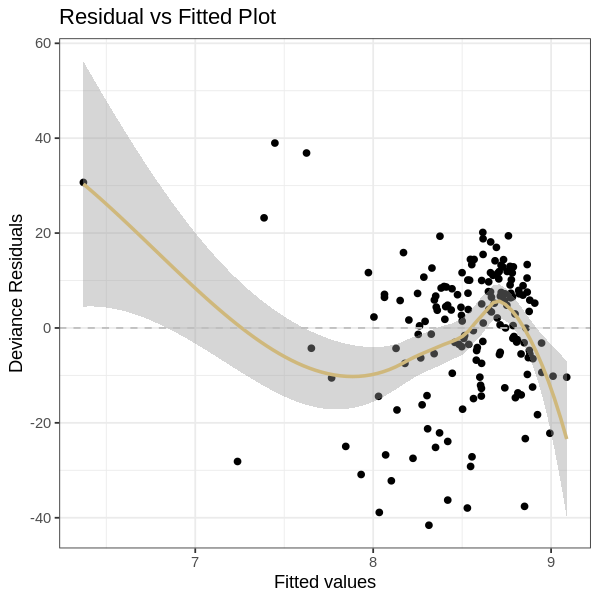

In [5]:
options(repr.plot.width = 5, repr.plot.height = 5)
p1 = ggplot(glm_bike, aes(.fitted, .resid))+geom_point()
p1 = p1+stat_smooth(method="loess", col = "#CFB87C")+geom_hline(yintercept=0, col="grey", linetype="dashed")
p1 = p1+xlab("Fitted values")+ylab("Deviance Residuals")
p1 = p1+ggtitle("Residual vs Fitted Plot")+theme_bw()
p1

We saw in a previous lesson that the deviance residuals should follow a roughly standard normal distribution. Here, we see some deviation from that assumption. In particular, there appears to be a longer tail in the negative direction. These pieces of evidence suggest that we either are missing predictors or we have overdispersion (these problems are related, in that a missing predictor can be the cause of overdispersion). Let's calculate an estimate of the deviance parameter.

In [6]:
dp = sum(residuals(glm_bike, type = "pearson")^2)/glm_bike$df.res
dp

[1] 205.7364

The overdispersion parameter estimate is very large (much greater than one), which suggests overdispersion is present. Based on this estimate, we should consider reasons why overdispersion might be present. Is it *real* overdispersion? Or *apparent* overdispersion?  Plausibly, there may be more factors that contribute to variability than weather and day of the week, which suggests real overdispersion through model mis-specification. Unfortunately, there are no other measured predictors in this dataset to experiment with. 

For practice with the quasi-likelihood methods, let's implement the quasi-Poisson regression method, using `family = quasipoisson`:

In [7]:
glm_bike_qp = glm(mb ~ precip + temp_h + temp_l + day, data = df_train, family = quasipoisson)
#or summary(glm_bike, dispersion = dp)
summary(glm_bike_qp)
summary(glm_bike)
cat("Confirming the standard error adjustment for the intercept: ", sqrt(205.736418003473)*0.0088089,".")


Call:
glm(formula = mb ~ precip + temp_h + temp_l + day, family = quasipoisson, 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.577   -7.122    2.309    8.523   38.973  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.760501   0.126352  61.420  < 2e-16 ***
precip       -0.673375   0.071029  -9.480  < 2e-16 ***
temp_h        0.023233   0.003346   6.943 8.92e-11 ***
temp_l       -0.013967   0.003620  -3.858 0.000165 ***
dayMonday     0.075862   0.055590   1.365 0.174261    
daySaturday  -0.199392   0.060552  -3.293 0.001219 ** 
daySunday    -0.261858   0.062257  -4.206 4.30e-05 ***
dayThursday   0.099943   0.055377   1.805 0.072980 .  
dayTuesday    0.141926   0.055155   2.573 0.010978 *  
dayWednesday  0.158057   0.055098   2.869 0.004675 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 205.7413)

    Null deviance: 110729 


Call:
glm(formula = mb ~ precip + temp_h + temp_l + day, family = poisson, 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.577   -7.122    2.309    8.523   38.973  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   7.7605007  0.0088089  880.98   <2e-16 ***
precip       -0.6733753  0.0049519 -135.98   <2e-16 ***
temp_h        0.0232326  0.0002333   99.59   <2e-16 ***
temp_l       -0.0139666  0.0002524  -55.34   <2e-16 ***
dayMonday     0.0758621  0.0038756   19.57   <2e-16 ***
daySaturday  -0.1993917  0.0042215  -47.23   <2e-16 ***
daySunday    -0.2618583  0.0043404  -60.33   <2e-16 ***
dayThursday   0.0999425  0.0038607   25.89   <2e-16 ***
dayTuesday    0.1419263  0.0038452   36.91   <2e-16 ***
dayWednesday  0.1580572  0.0038413   41.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 110729  on 17

Confirming the standard error adjustment for the intercept:  0.1263506 .

The Poisson model appears to be a bad fit. The quasi Poisson model adjusts the standard errors, and we see that that adjustment changes the significance of some of the levels of the day-of-week factor. We can test whether we should leave the day-of-week factor in the model. When comparing overdispersed models, where we're estimating a dispersion parameter $\phi$, we use an F-test. The `drop1()` function will conduct several F-tests, and we'll use it to extract the F-test associated with dropping the `day` factor.

In [8]:
drop1(glm_bike_qp, test = "F")

,Df,Deviance,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,34454.22,NA,NA
precip,1,58750.13,113.53154,2.131556e-20
temp_h,1,44350.69,46.24485,1.937634e-10
temp_l,1,37500.81,14.23629,2.262242e-04
day,6,53944.33,15.17911,9.716982e-14


 We see that the p-value for `day` is small ($F \approx 15.18$) and so we reject $H_0$ that the `day` factor is unnecessary, and choose to keep this factor in the model. At this point, without other predictors to use to explain variability, or imposing other assumptions on the data, this might be the best we can do!